In [2]:
#import boto3
from astropy.io import fits
from io import BytesIO
import sys
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
sys.path.append('/home/bekah/gPhoton2')
from gPhoton.coadd import zero_flag_and_edge
import pyarrow.parquet as parquet
import fast_histogram as fh
import time


In [ ]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    import numpy as np
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)

    if isinstance(image, np.ma.MaskedArray):
        return result

    return result.data

In [ ]:
nuv_drawn = fits.open("/media/bekah/BekahA/hotspot/drawn/nuv_spots.fits")
mask = nuv_drawn[0].data

In [ ]:
nf = parquet.read_table("/home/bekah/gPhoton2/test_data/e23456/e23456-nd-b00.parquet").to_pandas()

In [ ]:
nf = nf[(nf['row']*4 >= -200) & (nf['row']*4 <= 3400) & (nf['col']*4 >= -200) & (nf['col']*4 <= 3400)]

In [ ]:
nf['col_adj'] = nf['col']*(16/3)+200*(4/3)
nf['row_adj'] = nf['row']*(16/3)+200*(4/3)

In [ ]:
nf['row_rnd'] = nf['row_adj'].round().astype(int)
nf['col_rnd'] = nf['col_adj'].round().astype(int)

nf = nf[(nf['row_rnd'] <= 4799) & (nf['col_rnd'] <= 4799)]

mask = mask[nf['col_rnd'], nf['row_rnd']] == 1

nf['flagged'] = mask



In [ ]:
nf.keys()

In [ ]:
plt.scatter( nf[nf['flagged']]['col'],nf[nf['flagged']]['row'],s=.25)

In [ ]:
plt.scatter( nf[nf['flagged']]['ra'],nf[nf['flagged']]['dec'],s=.00001)
plt.xlim(322.75,324.25)
plt.ylim(-2.8,-1.4)

In [ ]:
nf['row_rnd2'] = nf['row'].round().astype(int)
nf['col_rnd2'] = nf['col'].round().astype(int)

In [ ]:
def converter(x):
    return (x-(200*(4/3)))*(3/16)

converter(2472)



In [ ]:
#pixel = nf[(nf['col_rnd2'] == 620) &(nf['row_rnd2'] == 223) ] # &(nf['row_rnd2'] == 400)
pixel = nf[(nf['col_rnd'] == 373) &(nf['row_rnd'] == 414) ]

In [ ]:
pixel

In [ ]:
plt.scatter(pixel['ra'],pixel['dec'],s=.15)

In [ ]:
plt.scatter(pixel['col'],pixel['row'],s=.15)

In [ ]:
plt.scatter(pixel['row'],pixel['col'])

In [ ]:
plt.hist(pixel['row_rnd2'],bins=100)

In [ ]:
# this is computationally very expensive 

import numpy as np
from scipy.spatial.distance import pdist, squareform

def average_dispersion(group):
    if len(group) < 2:
        return np.nan  
    coords = group[['ra', 'dec']].values
    pairwise_distances = pdist(coords, metric='euclidean')
    avg_dispersion = np.mean(pairwise_distances)
    return avg_dispersion

dispersion = nf.groupby(['col_rnd2', 'row_rnd2']).apply(average_dispersion).reset_index(name='average_dispersion')

nf = pd.merge(nf, dispersion, on=['col_rnd2', 'row_rnd2'])

In [ ]:
dispersion = nf.groupby(['col_rnd2', 'row_rnd2']).agg({
    'ra': 'std',
    'dec': 'std'
}).reset_index()

In [ ]:
plt.scatter(dispersion[dispersion['ra']>50]['col_rnd2'],dispersion[dispersion['ra']>50]['row_rnd2'],c=dispersion[dispersion['ra']>50]['dec']+dispersion[dispersion['ra']>50]['ra'],s=.5)

In [ ]:
dispersion

In [ ]:
plt.hist(dispersion['ra'],bins=50)

In [ ]:
dispersion.columns = ['col_rnd2', 'row_rnd2', 'ra_std', 'dec_std']


In [ ]:
# this crashes, uses too much memory, don't use 
nf = pd.merge(nf, dispersion, on=['col_rnd2', 'row_rnd2'])

In [ ]:
# ok so, make histogram / dosemap from points, identify hotspots and dark spots 
# then measure "dispersion" aka standard deviation of ra and dec for bright spots to determine if they're a 
# hotspot or a real star
# for coldspots you obviously can't measure dispersion if there's no points, so need to determine some kind of cutoff
#  based on the background rate 

# pre-filtering with the 2d histogram should significantly cut down on the time to calculate standard deviation 

In [3]:
def dosemap_ranges(radius):
    slop = 400 - radius
    return [slop, 3200 - slop], [slop, 3200 - slop]

def is_point_in_list(row, points_list):
    return (row['col'], row['row']) in points_list

In [4]:
# load and filter data for being on detector / in dosemap frame, convert to dosemap coords

nf = parquet.read_table("/home/bekah/gPhoton2/test_data/e23456/e23456-nd-b00.parquet",columns=['col', 'row', 'ra', 'dec', 'flat', 'response']).to_pandas()


In [5]:
# filter
nf = nf[(nf['row']*4 >= -200) & (nf['row']*4 <= 3400) & (nf['col']*4 >= -200) & (nf['col']*4 <= 3400)]

nf['col_adj'] = nf['col']*(16/3)+200*(4/3)
nf['row_adj'] = nf['row']*(16/3)+200*(4/3)

nf['row_rnd'] = nf['row'].round().astype(int)
nf['col_rnd'] = nf['col'].round().astype(int)

nf = nf[(nf['row_rnd'] <= 4799) & (nf['col_rnd'] <= 4799)]



In [6]:
nf = nf[(nf['ra']!= 0) & (nf['dec']!= 0) ]


In [ ]:
nf

In [9]:
start_time = time.time()

print("finished filtering data, making histogram now")

# make 2d histogram and filter for dark and hotpsots. "hotspots" will inevitably contain bright stars
#hist = fh.histogram2d(
#        nf['col'], nf['row'],bins=800, range=([0,800],[0,800])
#    ).astype('float32')

#print("done with histogram, selecting points")

#mask = (hist > 30) | (hist < 1)

print("calculating dispersion")

dispersion = nf.groupby(['col_rnd', 'row_rnd']).agg({
    'ra': 'std',
    'dec': 'std',
    'col': 'std',
    'row': 'std',
    'response': 'mean'
}).reset_index()

counts = nf.groupby(['col_rnd', 'row_rnd']).size().reset_index(name='count')

dispersion = pd.merge(dispersion, counts, on=['col_rnd', 'row_rnd'])

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

finished filtering data, making histogram now
calculating dispersion
it took 13.8146 seconds


In [ ]:
dispersion

In [ ]:
hist.shape

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(dispersion[dispersion['ra']>20]['col_rnd'],dispersion[dispersion['ra']>20]['row_rnd'],c=abs(dispersion[dispersion['ra']>20]['ra'])+abs(dispersion[dispersion['ra']>20]['dec']),s=.05)

In [ ]:
plt.hist(abs(dispersion[dispersion['ra']>20]['ra'])+abs(dispersion[dispersion['ra']>20]['dec']),bins=100)

In [30]:
hist = fh.histogram2d(
        nf['col'], nf['row'], bins=800, range=([0,800],[0,800])
    ).astype('float32')

In [ ]:
plt.scatter(dispersion['col_rnd'],dispersion['row_rnd'],s=.00002)
plt.xlim(0,800)
plt.ylim(0,800)

In [ ]:
dispersion = dispersion[(dispersion['col_rnd']<800)&(dispersion['row_rnd']<800)]
max_col = dispersion['col_rnd'].max()
max_row = dispersion['row_rnd'].max()

ra_dec_disp = np.zeros((max_col + 1, max_row + 1))

ra_dec_disp[dispersion['col_rnd'], dispersion['row_rnd']] = abs(dispersion['ra'])+abs(dispersion['dec'])

In [16]:
dispersion = dispersion[(dispersion['col_rnd']<800)&(dispersion['row_rnd']<800)]
max_col = dispersion['col_rnd'].max()
max_row = dispersion['row_rnd'].max()

response_map = np.zeros((max_col + 1, max_row + 1))

response_map[dispersion['col_rnd'], dispersion['row_rnd']] = dispersion['response']

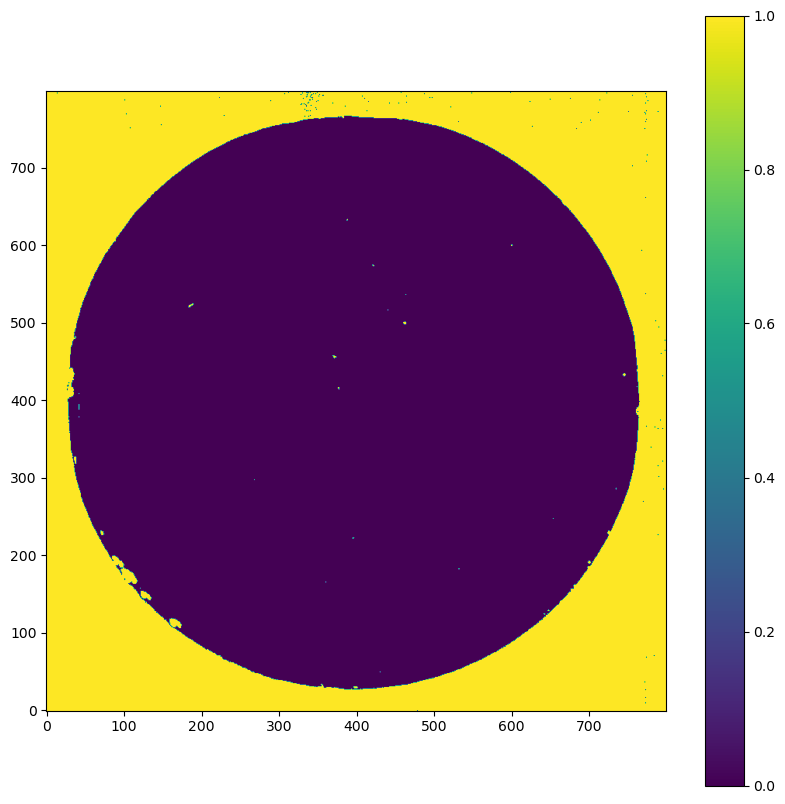

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.imshow(response_map<=.7,origin='lower',interpolation=None)
plt.colorbar()

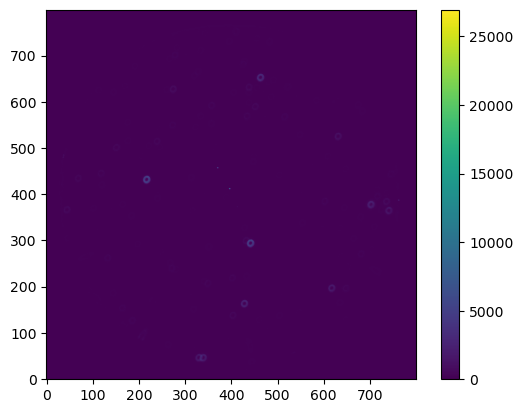

In [32]:
plt.imshow(hist,origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(np.isnan(high_disp))

In [ ]:
# density mask
mask1 = (hist > 85) | (hist < 20)

# dispersion mask
mask2 = (high_disp > 5) | np.isnan(high_disp)

# combo mask
result_array = np.zeros(hist.shape, dtype=int)

result_array[mask1 & mask2] = 2
result_array[mask1 & ~mask2] = 1
result_array[~mask1 & mask2] = -1


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(result_array, interpolation=None, origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(centile_clip(hist),origin='lower',interpolation=None)
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))

plt.imshow(mask2,interpolation=None)
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))

plt.imshow(mask1,interpolation=None)
plt.colorbar()

In [ ]:
nf.keys()


In [ ]:
plt.scatter(nf['ra'],nf['dec'],c=nf['response'],s=.0005)

In [10]:
hotspot1 = dispersion[(dispersion['col_rnd'] == 412) &(dispersion['row_rnd'] == 397) ]
hotspot2 =  dispersion[(dispersion['col_rnd'] == 373) &(dispersion['row_rnd'] == 414) ]
hotspot3 =  dispersion[(dispersion['col_rnd'] == 484) &(dispersion['row_rnd'] == 38) ]

coldspot =  dispersion[(dispersion['col_rnd'] == 501) &(dispersion['row_rnd'] == 462) ]

brightstar =  dispersion[(dispersion['col_rnd'] == 652) &(dispersion['row_rnd'] == 470) ]

starinterior1 =  dispersion[(dispersion['col_rnd'] == 431) &(dispersion['row_rnd'] == 217) ]
starinterior2 =  dispersion[(dispersion['col_rnd'] == 652) &(dispersion['row_rnd'] == 464) ]

background =  dispersion[(dispersion['col_rnd'] == 325) &(dispersion['row_rnd'] == 227) ]

In [ ]:
pixel = dispersion[(dispersion['col_rnd'] == 652) &(dispersion['row_rnd'] == 470) ]

In [15]:
coldspot

,col_rnd,row_rnd,ra,dec,col,row,response,count
298339,501,462,NaN,NaN,NaN,NaN,0.125263,1


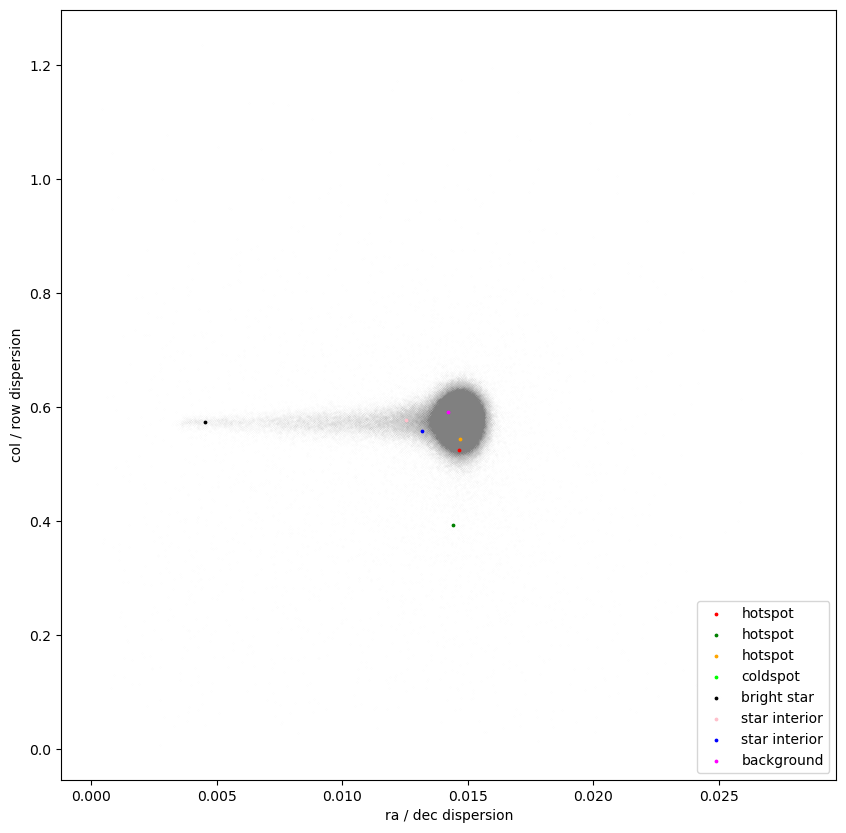

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(abs(dispersion['ra'])+abs(dispersion['dec']),abs(dispersion['col'])+abs(dispersion['row']),c='grey',s=0.00005)
plt.xlabel('ra / dec dispersion')
plt.ylabel('col / row dispersion')

plt.scatter(abs(hotspot1['ra'])+abs(hotspot1['dec']),abs(hotspot1['col'])+abs(hotspot1['row']),s=3,c='red',label='hotspot')
plt.scatter(abs(hotspot2['ra'])+abs(hotspot2['dec']),abs(hotspot2['col'])+abs(hotspot2['row']),s=3,c='green',label='hotspot')
plt.scatter(abs(hotspot3['ra'])+abs(hotspot3['dec']),abs(hotspot3['col'])+abs(hotspot3['row']),s=3,c='orange',label='hotspot')
plt.scatter(abs(coldspot['ra'])+abs(coldspot['dec']),abs(coldspot['col'])+abs(coldspot['row']),s=3,c='lime',label='coldspot')
plt.scatter(abs(brightstar['ra'])+abs(brightstar['dec']),abs(brightstar['col'])+abs(brightstar['row']),s=3,c='black',label='bright star')
plt.scatter(abs(starinterior1['ra'])+abs(starinterior1['dec']),abs(starinterior1['col'])+abs(starinterior1['row']),s=3,c='pink',label='star interior')
plt.scatter(abs(starinterior2['ra'])+abs(starinterior2['dec']),abs(starinterior2['col'])+abs(starinterior2['row']),s=3,c='blue',label='star interior')
plt.scatter(abs(background['ra'])+abs(background['dec']),abs(background['col'])+abs(background['row']),s=3,c='magenta',label='background')

plt.legend(loc=4)

In [ ]:
plt.scatter(abs(dispersion['ra'])+abs(dispersion['dec']),dispersion['response'],c=abs(dispersion['col'])+abs(dispersion['row']),s=0.0005)
plt.xlabel('ra / dec dispersion')
plt.ylabel('std response')


In [ ]:
plt.scatter(dispersion['count'],dispersion['response'],c=abs(dispersion['ra'])+abs(dispersion['dec']),s=0.05)
plt.xlabel('cound')
plt.ylabel('mean response')
plt.scatter(hotspot1['count'],hotspot1['response'],s=3,c='red',label='hotspot')
plt.scatter(hotspot2['count'],hotspot2['response'],s=3,c='green',label='hotspot')
plt.scatter(hotspot3['count'],hotspot3['response'],s=3,c='orange',label='hotspot')
plt.scatter(coldspot['count'],coldspot['response'],s=3,c='lightblue',label='coldspot')
plt.scatter(brightstar['count'],brightstar['response'],s=3,c='black',label='bright star')
plt.scatter(starinterior1['count'],starinterior1['response'],s=3,c='pink',label='star interior')
plt.scatter(starinterior2['count'],starinterior2['response'],s=3,c='blue',label='star interior')
plt.scatter(background['count'],background['response'],s=3,c='magenta',label='background')

plt.legend()


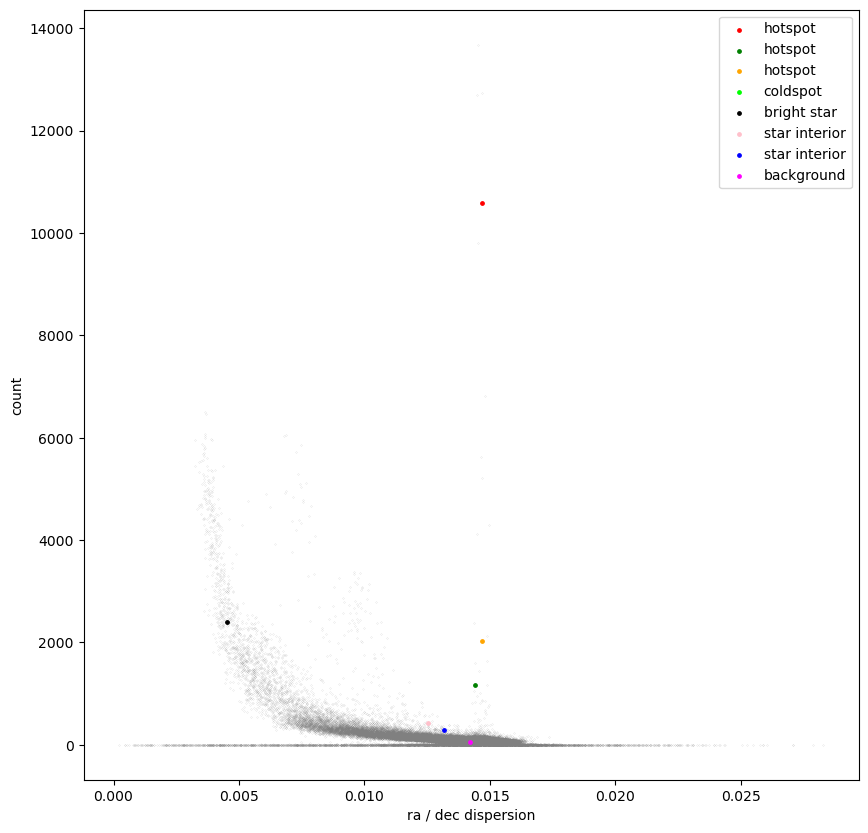

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(abs(dispersion['ra'])+abs(dispersion['dec']),dispersion['count'],c='grey',s=0.005)
plt.xlabel('ra / dec dispersion')
plt.ylabel('count')

plt.scatter(abs(hotspot1['ra'])+abs(hotspot1['dec']),hotspot1['count'],s=6,c='red',label='hotspot')
plt.scatter(abs(hotspot2['ra'])+abs(hotspot2['dec']),hotspot2['count'],s=6,c='green',label='hotspot')
plt.scatter(abs(hotspot3['ra'])+abs(hotspot3['dec']),hotspot3['count'],s=6,c='orange',label='hotspot')
plt.scatter(abs(coldspot['ra'])+abs(coldspot['dec']),coldspot['count'],s=6,c='lime',label='coldspot')
plt.scatter(abs(brightstar['ra'])+abs(brightstar['dec']),brightstar['count'],s=6,c='black',label='bright star')
plt.scatter(abs(starinterior1['ra'])+abs(starinterior1['dec']),starinterior1['count'],s=6,c='pink',label='star interior')
plt.scatter(abs(starinterior2['ra'])+abs(starinterior2['dec']),starinterior2['count'],s=6,c='blue',label='star interior')
plt.scatter(abs(background['ra'])+abs(background['dec']),background['count'],s=6,c='magenta',label='background')

plt.legend()

In [ ]:
plt.scatter(dispersion['col_rnd'],dispersion['row_rnd'],c=dispersion['response'],s=.0005)